# Tarea 1: Classificaton Fine-tuning

Esta tarea consiste en desarrollar por vuestra cuenta un modelo de *Text-Classification*. En clase ya hemos visto este caso de uso y debería resultaros sencilla la transición. En cualquier caso, esta vez trabajaréis solos. Prestad atención a todos los pasos y no dudéis en utilizar cualquier recurso para investigar.  

El dataset está seleccionado al comienzo del notebook. Sin embargo, la elección, configuración y entrenamiento del modelo es totalmente libre. No olvidéis que el notebook tiene que estar entregado con todas las celdas ejecutadas y sin errores, incluidas las celdas de evaluación al final del notebook.

In [1]:
# Librerías

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())

from time import time
from datasets import *
from transformers import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

Is CUDA available: True
CUDA version: 12.6
Number of GPUs available: 1
🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Config not found for parakeet. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py


TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


## Dataset

El split **MNLI** del dataset **GLUE** consiste en un par de oraciones (premisa e hipótesis) y una etiqueta indicando la relación entre ellas:

- _Entailment_: La hipótesis es una conclusión lógica de la premisa.
- _Neutral_: La hipótesis no puede ser determinada como verdadera o falsa basada en la premisa.
- _Contradiction_: La hipótesis contradice la premisa.

Además, este split contiene diferentes subconjuntos. Principalmente, usaremos el de _train_ para entrenar y los de _validation_ para evaluar la calidad del modelo. Los de _test_ los omitiremos para este trabajo.
- _Train_: Dataset que usaremos para entrenar el modelo.
- _MNLI-matched_ (MNLI-m): Dataset de validación creado a partir de las mismas categorías de los del conjunto de entrenamiento (e.g., noticias, ficción).
- _MNLI-mismatched_ (MNLI-mm): Dataset de validación creado a partir de diferentes categorías de los del conjunto de entrenamiento (e.g., discursos políticos, cartas).

Aquí la ficha del dataset para que podáis explorarla: https://huggingface.co/datasets/nyu-mll/glue

In [2]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

dataset = load_dataset("glue", "mnli")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Con el único motivo de no demorar los tiempos de entrenamiento. Filtraremos el dataset y nos quedaremos solo con los registros que tenga longitud del campo _premise_ inferior a 20.

El resto de la práctica se pide trabajarla sobre la variable `dataset` ya filtrada.

In [3]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def filter_rows(x):
    return len(x['premise'])<20
dataset = dataset.filter(filter_rows)

assert len(dataset['train']) == 13635
assert len(dataset['validation_matched']) == 413
assert len(dataset['validation_mismatched']) == 296

dataset

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 288
    })
})

## Modeling

En este apartado es donde tendréis que realizar todo el trabajo de la práctica. El formato, el análisis, el modelo escogido y cualquier proceso intermedio que consideréis es totalmente libre. Sin embargo, hay algunas pautas que tendréis que cumplir:

- La variable `model_checkpoint` debe almacenar el nombre del modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `model` y la variable `tokenizer` almacenarán, respectivamente, el modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `trainer` almacenará el _Trainer_ de 🤗 que, en la siguiente sección utilizaréis para entrenar el modelo.
- Debe existir una función llamada `preprocess_function` que realice la tokenización y, si lo consideráis oportuno, transformaciones de las _features_.

Nota: En el _tokenizer_, es obligatorio que su salida sean **tensores** de pytorch.

**Importante**
No está permitido utilizar modelos pre-entrenados de Huggingface que han sido ya entrenados con este dataset, `GLUE MNIST`. Por ejemplo, no se permitiría usar `deberta-large-mnli`, `roberta-base-MNLI`, `glue_sst_classifier`, etc.

In [4]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

label_list = dataset["train"].features["label"].names \
    if hasattr(dataset["train"].features["label"], "names") \
    else sorted(list(set(dataset["train"]["label"])))
num_labels = len(label_list)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels
)

def preprocess_function(examples):

    tokenized_inputs = tokenizer(
        examples["premise"],
        examples["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )


    labels = examples.get("label", None)

    if isinstance(labels, list):

        tokenized_inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    else:

        pass

    return tokenized_inputs


tokenized_datasets = dataset.map(preprocess_function, batched=True)


tokenized_datasets = tokenized_datasets.remove_columns(["premise", "hypothesis", "idx"])

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).astype(float).mean()}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation_matched"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "architectures"

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/model.safetensors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkp

Map:   0%|          | 0/13635 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

PyTorch: setting up devices
/tmp/ipython-input-1179794588.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training

In [5]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

assert len(trainer.train_dataset) == 13635

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

***** Running training *****
  Num examples = 13,635
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5,115
  Number of trainable parameters = 124,647,939


Epoch,Training Loss,Validation Loss,Accuracy
1,0.592100,0.440064,0.832930
2,0.436000,0.445816,0.852300
3,0.340200,0.577160,0.859564



***** Running Evaluation *****
  Num examples = 413
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-1705
Configuration saved in ./results/checkpoint-1705/config.json
Model weights saved in ./results/checkpoint-1705/model.safetensors
tokenizer config file saved in ./results/checkpoint-1705/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1705/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 413
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-3410
Configuration saved in ./results/checkpoint-3410/config.json
Model weights saved in ./results/checkpoint-3410/model.safetensors
tokenizer config file saved in ./results/checkpoint-3410/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3410/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 413
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-5115
Configuration saved in ./results/checkpoint-5115/config.jso

>>>>>>>>>>>>> elapsed time: 4m


## Evaluation

In [6]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

print(f"**** EVALUACIÓN ****")
print(f"********\nTokenizer config:\n{tokenizer}")
print(f"\n\n********\nModel config:\n{model.config}")
print(f"\n\n********\nTrainer arguments:\n{trainer.args}")

**** EVALUACIÓN ****
********
Tokenizer config:
RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)


********
Model config:
RobertaConfig {
  "architectu

In [7]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

sample = dataset['validation_matched'][0]
inputs = preprocess_function(sample)
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} es una instancia de torch.Tensor")
    else:
        print(f"{key} no es una instancia de torch.Tensor")

input_ids es una instancia de torch.Tensor
attention_mask es una instancia de torch.Tensor


In [8]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict(x):
    inputs = preprocess_function(x)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        return {'prediction': predictions.item()}

ds_predictions = dataset.map(predict)

assert len(ds_predictions['train']) == 13635
assert len(ds_predictions['validation_matched']) == 413
assert len(ds_predictions['validation_mismatched']) == 296

ds_predictions

Map:   0%|          | 0/13635 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 288
    })
})

*** train ***


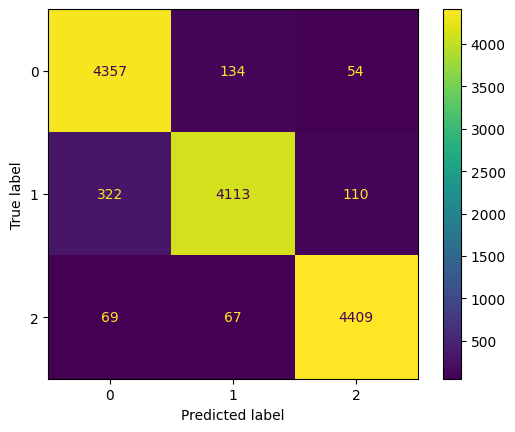

*** validation_matched ***


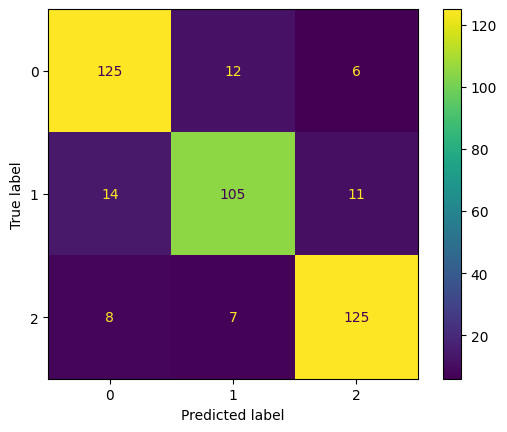

*** validation_mismatched ***


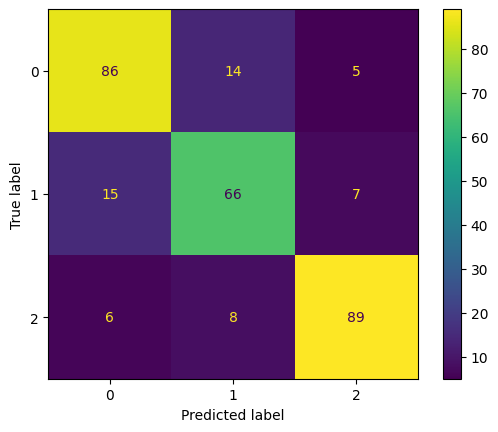

In [9]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(f"*** {subset} ***")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [10]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

metrics = {}
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    pre = precision_score(y_true=y_true, y_pred=y_pred, average=None)
    rec = recall_score(y_true=y_true, y_pred=y_pred, average=None)
    metrics[subset] = [acc] + pre.tolist() + rec.tolist()
    print(f"Subset: {subset}:")
    print(f"Accuracy: {acc:.2f} | Precision0: {pre[0]:.2f} | Precision1: {pre[1]:.2f} | Precision2: {pre[2]:.2f} | Recall0: {rec[0]:.2f} | Recall1: {rec[1]:.2f} | Recall2: {rec[2]:.2f}")
    print("-----\n")

Subset: train:
Accuracy: 0.94 | Precision0: 0.92 | Precision1: 0.95 | Precision2: 0.96 | Recall0: 0.96 | Recall1: 0.90 | Recall2: 0.97
-----

Subset: validation_matched:
Accuracy: 0.86 | Precision0: 0.85 | Precision1: 0.85 | Precision2: 0.88 | Recall0: 0.87 | Recall1: 0.81 | Recall2: 0.89
-----

Subset: validation_mismatched:
Accuracy: 0.81 | Precision0: 0.80 | Precision1: 0.75 | Precision2: 0.88 | Recall0: 0.82 | Recall1: 0.75 | Recall2: 0.86
-----



### Criterio de evaluación

La **nota final de la tarea1** estará relacionada con el resultado de las métricas de vuestro modelo en la combinación de *accuracy*, *precision* y *recall* para cada _split_ de datos.

El criterio de evaluación será el siguiente:
- La tarea1 se aprobará si el notebook se entrega sin fallos y con un modelo entrenado (independientemente de sus métricas).
- La tarea1 tiene un 10 si se cumple que las métricas de vuestro modelo entrenado igualan o superan los siguientes umbrales:

| Subset               | Accuracy | Precision0 | Precision1 | Precision2 | Recall0 | Recall1 | Recall2 |
|----------------------|----------|------------|------------|------------|---------|---------|---------|
| validation_matched    | 0.78     | 0.78       | 0.76       | 0.85       | 0.80    | 0.77    | 0.81    |
| validation_mismatched | 0.79     | 0.70       | 0.70       | 0.70       | 0.65    | 0.71    | 0.85    |

- Por cada valor inferior a dicha métrica, la tarea pierde 0.5 puntos (máximo 5.0 puntos de pérdida).

Nota: La nota que se calcula a continuación es orientativa y podría verse reducida en función del código de la entrega.

In [11]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def calculo_nota(metric):

    vm_acc = float(metric['validation_matched'][0])
    vm_pre0 = float(metric['validation_matched'][1])
    vm_pre1 = float(metric['validation_matched'][2])
    vm_pre2 = float(metric['validation_matched'][3])
    vm_rec0 = float(metric['validation_matched'][4])
    vm_rec1 = float(metric['validation_matched'][5])
    vm_rec2 = float(metric['validation_matched'][6])
    vmm_acc = float(metric['validation_mismatched'][0])
    vmm_pre0 = float(metric['validation_mismatched'][1])
    vmm_pre1 = float(metric['validation_mismatched'][2])
    vmm_pre2 = float(metric['validation_mismatched'][3])
    vmm_rec0 = float(metric['validation_mismatched'][4])
    vmm_rec1 = float(metric['validation_mismatched'][5])
    vmm_rec2 = float(metric['validation_mismatched'][6])

    thresholds = {
        'vm_acc': 0.78, 'vm_pre0': 0.78, 'vm_pre1': 0.76, 'vm_pre2': 0.85,
        'vm_rec0': 0.80, 'vm_rec1': 0.77, 'vm_rec2': 0.81,
        'vmm_acc': 0.79, 'vmm_pre0': 0.70, 'vmm_pre1': 0.70, 'vmm_pre2': 0.70,
        'vmm_rec0': 0.65, 'vmm_rec1': 0.71, 'vmm_rec2': 0.85,
    }
    values = {
        'vm_acc': vm_acc, 'vm_pre0': vm_pre0, 'vm_pre1': vm_pre1, 'vm_pre2': vm_pre2,
        'vm_rec0': vm_rec0, 'vm_rec1': vm_rec1, 'vm_rec2': vm_rec2,
        'vmm_acc': vmm_acc, 'vmm_pre0': vmm_pre0, 'vmm_pre1': vmm_pre1, 'vmm_pre2': vmm_pre2,
        'vmm_rec0': vmm_rec0, 'vmm_rec1': vmm_rec1, 'vmm_rec2': vmm_rec2,
    }

    nota = 10
    for key in thresholds:
        if values[key] < thresholds[key]:
            nota -= 0.5
    return max(nota, 5.0)

print(f"Tu nota de la tarea1 es: {calculo_nota(metrics)}")

Tu nota de la tarea1 es: 10
